In [1]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim
import time
from torchvision import transforms
from PIL import Image
from sklearn.metrics import (
accuracy_score, precision_score, recall_score,
f1_score, confusion_matrix, classification_report
)
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from torch.utils.data import random_split

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
%load_ext autoreload
%autoreload 2

In [27]:
transform = transforms.Compose([
transforms.ToTensor(),
# transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128

train_subset, _ = random_split(train_dataset, [500, len(train_dataset) - 500])
test_subset, _ = random_split(test_dataset, [100, len(test_dataset) - 100])

# Create DataLoader with subset
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

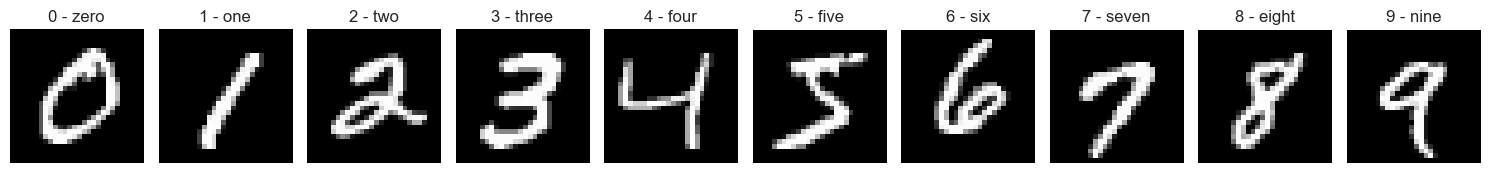

In [13]:
classes = train_dataset.classes

samples = {}
for img, label in train_dataset:
    if label not in samples:
        samples[label] = img
    if len(samples) == len(classes):
        break

# Plot the images.
fig, axs = plt.subplots(1, len(classes), figsize=(15, 4))
for label, ax in enumerate(axs):
    img_np = samples[label].permute(1, 2, 0).numpy()
    ax.imshow(img_np, cmap='gray')
    ax.set_title(classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()


In [20]:
def softmax(x):
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    exps = np.exp(x_shifted)
    return exps / np.sum(exps, axis=1, keepdims=True)


def l2_regularization(W, reg_strength):
    loss = np.sum(np.square(W)) * reg_strength
    grad = 2 * reg_strength * W
    return loss, grad


def softmax_with_cross_entropy(predictions, target_index):
    batch_size = predictions.shape[0]
    probs = softmax(predictions)
    correct_probs = probs[np.arange(batch_size), target_index]
    loss = -np.sum(np.log(correct_probs)) / batch_size  # Average loss
    d_pred = probs.copy()
    d_pred[np.arange(batch_size), target_index] -= 1
    d_pred /= batch_size  # Normalize gradient
    return loss, d_pred


class Param:
    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)


class ReLULayer:
    def __init__(self):
        self.mask = None

    def forward(self, X):
        self.mask = X > 0
        X = X * self.mask
        return X

    def backward(self, d_out):
        d_result = d_out * self.mask

        return d_result

    def params(self):
        return {}


class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(0.001 * np.random.randn(n_input, n_output))
        self.B = Param(0.001 * np.random.randn(1, n_output))
        self.X = None

    def forward(self, X):
        self.X = X

        return X @ self.W.value + self.B.value

    def backward(self, d_out):
        d_input = d_out @ self.W.value.T

        d_W = self.X.T @ d_out
        self.W.grad += d_W

        d_B = np.sum(d_out, axis=0, keepdims=True)
        self.B.grad += d_B

        return d_input

    def params(self):
        return {'W': self.W, 'B': self.B}


class Model:
    def __init__(self, layers):
        """
        Initialize the model with a list of layers.
        """
        self.layers = layers
        self.last_output = None

    def forward(self, x):
        """
        Perform a forward pass through all layers.
        """
        for layer in self.layers:
            x = layer.forward(x)

        self.last_output = x
        return x

    def backward(self, grad):
        """
        Backpropagate the gradient through all layers.
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def grad_cam(self):
        input_grad = self.backward(self.last_output)
        self.clear_params()

        return input_grad


    def compute_loss_and_grad(self, predictions, target_index):
        """
        Compute the softmax with cross entropy loss and return both the loss
        and the gradient.
        """
        loss, grad = softmax_with_cross_entropy(predictions, target_index)
        return loss, grad

    def params(self):
        """
        Collects parameters from all layers.
        Returns a dictionary mapping layer names to their parameters.
        """
        parameters = {}
        for idx, layer in enumerate(self.layers):
            for name, param in layer.params().items():
                parameters[f"layer{idx}_{name}"] = param
        return parameters

    def clear_params(self):
        """
        Clear all parameters.
        """
        for param in self.params().values():
            param.grad = np.zeros_like(param.grad)

    def update_params(self, lr):
        """
        Updates all parameters.
        """
        for param in self.params().values():
            param.value -= lr * param.grad
            param.grad = np.zeros_like(param.grad)

    def train(self, lr, epochs, data_loader):
        """
        Trains the model.
        data_loader should yield batches as (x, y) where:
          - x is input with shape (batch_size, input_size)
          - y contains the target class indices for each sample.
        """
        loss_list = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            for x, y in data_loader:
                # Forward pass: compute predictions for the current batch.
                predictions = self.forward(x)

                # Compute loss and gradient at the output.
                loss, grad = self.compute_loss_and_grad(predictions, y)
                epoch_loss += loss

                # Backward pass: propagate gradients through the network.
                self.backward(grad)

                # Update all parameters using gradient descent.
                self.update_params(lr)

            avg_loss = epoch_loss / len(data_loader)
            loss_list.append(avg_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

        # Plot training loss.
        plt.plot(loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()


import numpy as np

class ConvolutionalLayer:
    def __init__(self, in_channels, out_channels,
                 filter_size, padding):
        self.filter_size = filter_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = Param(
            np.random.randn(filter_size, filter_size, in_channels, out_channels) * np.sqrt(
                2.0 / (filter_size * filter_size * in_channels))
        )

        self.B = Param(np.zeros(out_channels))

        self.padding = padding

        self.last_X = None

    def forward(self, X):
        # get shape of the input tensor
        batch_size, in_channels, height, width = X.shape

        # compute shape of output tensor
        out_height = height - self.filter_size + 1 + 2 * self.padding
        out_width = width - self.filter_size + 1 + 2 * self.padding

        # pad the input tensor
        X = np.pad(X, ((0, 0), (0, 0), (self.padding,) * 2, (self.padding,) * 2))

        # save last input for backward pass
        self.last_X = X

        # create zeros tensor for result
        result = np.zeros((batch_size, self.out_channels, out_height, out_width))

        # reshape weights to use matrix multiplication trick
        weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size, self.out_channels)

        # iterate each pixel in output tensor
        for y in range(out_height):
            for x in range(out_width):
                # take the perception widow of the output pixel
                patch = X[:, :, y:y + self.filter_size, x:x + self.filter_size]

                # unwrap patch to use matrix multiplication trick
                patch_flat = patch.reshape(batch_size, self.in_channels * self.filter_size * self.filter_size)

                # convolution operation
                res = patch_flat @ weights

                # add bias to result
                res += self.B.value

                # add pixels to result tensor
                result[:, :, y, x] = res

        return result

    def backward(self, d_out):
        # get shape of last input passed to forward pass
        batch_size, in_channels, height, width = self.last_X.shape

        # get shape of the received gradient
        _, out_channels, out_height, out_width = d_out.shape

        # create d_input with proper shape
        d_X = np.zeros_like(self.last_X)

        # get and reshape weights to use in calculations
        weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size, self.out_channels)

        for y in range(out_height):
            for x in range(out_width):
                # take the gradient patch (batch_size, out_channels)
                gradient_patch = d_out[:, :, y, x]

                # get and reshape input patch to (batch_size, self.in_channels*self.filter_size*self.filter_size)
                input_patch = self.last_X[:, :, y:y + self.filter_size, x:x + self.filter_size]
                input_patch_flat = input_patch.reshape(batch_size,
                                                       self.in_channels * self.filter_size * self.filter_size)

                # d_X to get gradient with respect to input -> d_out + weights

                d_input_flat = gradient_patch @ weights.T

                d_input_patch = d_input_flat.reshape(batch_size, in_channels, self.filter_size, self.filter_size)

                d_X[:, :, y:y + self.filter_size, x:x + self.filter_size] += d_input_patch

                # d_w gradient with respect to weights -> d_out + inputs
                d_flat_w = input_patch_flat.T @ gradient_patch

                d_w = d_flat_w.reshape(self.filter_size, self.filter_size, self.in_channels, self.out_channels)

                self.W.grad += d_w

                # d_b gradient with respect to bias term -> d_out

                d_b = np.sum(gradient_patch, axis=0)

                self.B.grad += d_b

        # return d_X without padding
        return d_X[:, :, self.padding:-self.padding, self.padding:-self.padding] if self.padding > 0 else d_X

    def params(self):
        return {'W': self.W, 'B': self.B}
class MaxPoolingLayer:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.X = None

    def forward(self, X):
        batch_size, channels, height, width = X.shape

        self.X = X

        # compute output tensor size
        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1

        # init resulting tensor with proper shape
        result = np.zeros((batch_size, channels, out_height, out_width))

        for y in range(out_height):
            for x in range(out_width):
                start_y = y * self.stride
                start_x = x * self.stride

                # take input patch
                patch = X[:, :, start_y:start_y + self.pool_size, start_x:start_x + self.pool_size]

                # get maximum over axis (1,2) means for each batch(0) and chanel(3) get the maximum of matrix (pool_size, pool_size) that stores actual pixel values
                patch_max = np.max(patch, axis=(2, 3))

                # assign maximum over each batch and chanel to the point in result tensor
                result[:, :, y, x] = patch_max

        return result

    def backward(self, d_out):
        batch_size, channels, height, width = self.X.shape

        d_input = np.zeros_like(self.X)

        out_width = (width - self.pool_size) // self.stride + 1
        out_height = (height - self.pool_size) // self.stride + 1

        for y in range(out_height):
            for x in range(out_width):
                input_patch = self.X[:, :, y * self.stride:y * self.stride + self.pool_size,
                              x * self.stride:x * self.stride + self.pool_size]

                # Flatten each patch for max index computation
                input_patch_reshaped = input_patch.reshape(batch_size, channels, -1)

                # Find the index of the maximum value in each patch
                max_idx_local = np.argmax(input_patch_reshaped, axis=2)

                # Convert flat indices back to 2D indices
                row_idx_local, col_idx_local = np.unravel_index(max_idx_local, (self.pool_size, self.pool_size))

                # Convert local indices to global indices in the input tensor
                row_idx_global = row_idx_local + y * self.stride
                col_idx_global = col_idx_local + x * self.stride

                # Batch and channel indices for broadcasting
                batch_idx = np.arange(batch_size)[:, None]
                ch_idx = np.arange(channels)

                # Accumulate gradient values at the positions of the max values
                d_input[batch_idx, ch_idx, row_idx_global, col_idx_global] += d_out[:, :, y, x]

        return d_input

    def params(self):
        return {}


class Flattener:
    def __init__(self):
        self.X_shape = None

    def forward(self, X):
        batch_size, channels, height, width = X.shape

        self.X_shape = X.shape

        return X.reshape(batch_size, -1)

    def backward(self, d_out):
        return d_out.reshape(self.X_shape)

    def params(self):
        return {}

In [21]:
class MomentumSGD:
    def __init__(self, momentum=0.9):
        self.momentum = 0.9
        self.velocities = {}

    def update(self, w, d_w, learning_rate, param_name):
        if param_name not in self.velocities:
            self.velocities[param_name] = np.zeros_like(w)

        self.velocities[param_name] = self.momentum * self.velocities[param_name] - learning_rate * d_w

        return w + self.velocities[param_name]

def train_model(model, train_loader, test_loader, epochs, lr, optimizer=MomentumSGD(), save_path=None):
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    for epoch in range(epochs):
        # Training phase
        model.train_mode = True
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0
        batch_count = 0

        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 30)

        for x, y in train_loader:
            # Data conversion and transfer

            x = x.numpy().astype(np.float32)
            y = y.numpy()

            # Forward pass
            predictions = model.forward(x)

            # Loss computation
            loss, grad = softmax_with_cross_entropy(predictions, y)

            # Calculate training accuracy
            pred_classes = np.argmax(predictions, axis=1)
            correct_train += np.sum(pred_classes == y)
            total_train += len(y)

            # Backward pass
            model.backward(grad)

            # Parameter update
            for param_name, param in model.params().items():
                param.value = optimizer.update(param.value, param.grad, lr, param_name)
                param.grad = np.zeros_like(param.grad)

            epoch_loss += loss
            batch_count += 1

        # Calculate training metrics
        avg_train_loss = epoch_loss / batch_count
        train_accuracy = (correct_train / total_train) * 100
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)

        # Testing phase
        model.train_mode = False
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        test_batch_count = 0

        for x, y in test_loader:
            # Data conversion and transfer

            x = x.numpy().astype(np.float32)
            y = y.numpy()

            # Forward pass only (no backward pass during testing)
            predictions = model.forward(x)

            # Calculate test loss
            batch_loss, _ = softmax_with_cross_entropy(predictions, y)
            test_loss += batch_loss

            # Calculate test accuracy
            pred_classes =  np.argmax(predictions, axis=1)
            correct_test += np.sum(pred_classes == y)
            total_test += len(y)

            test_batch_count += 1

        # Calculate test metrics
        avg_test_loss = test_loss / test_batch_count
        test_accuracy = (correct_test / total_test) * 100
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_accuracy)

        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
        print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")

    return history


In [22]:
model = Model([
    ConvolutionalLayer(1, 16, 3, 1),  # Input: 1 channel, Output: 16 channels, 3x3 kernel, padding 1
    ReLULayer(),
    ConvolutionalLayer(16, 32, 3, 1),  # 16 -> 32 channels, 3x3 kernel, padding 1
    ReLULayer(),
    MaxPoolingLayer(2, 2),  # 2x2 pooling with stride 2 -> output 32 * 14 * 14

    Flattener(),
    FullyConnectedLayer(32 * 14 * 14, 10),
])

In [23]:
epochs = 4
learning_rate = 0.001
train_history = train_model(model, train_loader, test_loader, epochs, learning_rate)

Epoch 1/4
------------------------------
Train Loss: 2.2659 | Train Acc: 19.00%
Test Loss: 2.1511 | Test Acc: 42.72%
Epoch 2/4
------------------------------
Train Loss: 2.0417 | Train Acc: 47.00%
Test Loss: 1.8934 | Test Acc: 48.98%
Epoch 3/4
------------------------------
Train Loss: 1.7262 | Train Acc: 60.80%
Test Loss: 1.5516 | Test Acc: 69.66%
Epoch 4/4
------------------------------
Train Loss: 1.3964 | Train Acc: 76.60%
Test Loss: 1.2505 | Test Acc: 76.28%


In [26]:
model.grad_cam()[0, :, :, :].shape

(1, 28, 28)

In [76]:
input = train_dataset[2][0]
input_batched = torch.stack([input], dim=0)

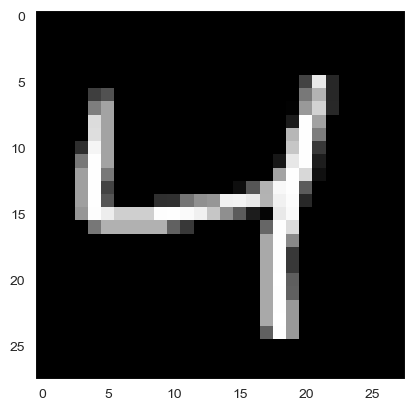

In [77]:
plt.imshow(input.permute(1, 2, 0).numpy(), cmap='gray')
plt.grid(False)
plt.show()

In [78]:
logits = model.forward(input_batched)

probs = softmax(logits)

probs

array([[0.09643226, 0.02180152, 0.07162451, 0.08065472, 0.30939257,
        0.06542283, 0.08352737, 0.06891228, 0.07016425, 0.13206768]])

In [79]:
prediction = np.argmax(probs, axis=1)

prediction

array([4])

In [80]:
grad_cam_mask = model.grad_cam()[0]

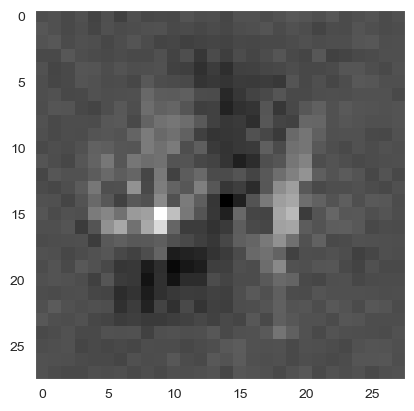

In [81]:
plt.imshow(grad_cam_mask.transpose(1, 2, 0), cmap='gray')
plt.grid(False)
plt.show()